In [37]:
import networkx as nx
import os
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric.nn as pyg_nn
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.preprocessing import MinMaxScaler
from torch_geometric.loader.dataloader import DataLoader
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn import metrics
from torch_geometric.loader import ClusterData, ClusterLoader

### Visualize graph

In [2]:
def draw_example(G, node):

    sample = G.edge_subgraph(G.edges(node))
    sample_copy = sample.copy()
    node_type = sample.nodes[node]["type"]
    connected_nodes = [(u, d) for u, d in G.nodes(data=True) if d["type"] != node_type]
    np.random.seed(42)
    null_nodes = [connected_nodes[i] for i in np.random.choice(range(len(connected_nodes)), len(sample.edges))]
    null_edges = [
        (node, end_node[0], {"load": 0, 'distance': np.random.choice(range(100, 10000))}) for end_node in null_nodes
        ]
    sample_copy.add_nodes_from(null_nodes)
    sample_copy.add_edges_from(null_edges)
    properties = {node: {j: d["distance"] for i, j, d in sample_copy.edges(data=True)}}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), facecolor=(1, 1, 1))

    ax1.set_title("Initial graph", size=16)
    nx.draw_networkx(
        sample_copy, 
        nodelist=list(sample.nodes()),
        edgelist=list(sample.edges()),
        with_labels=False, 
        node_size=100,
        linewidths=1.5,
        node_color=["green" if d["type"] == "house" else "steelblue" for u, d in sample.nodes(data=True)],
        pos=nx.kamada_kawai_layout(sample_copy, properties), ax=ax1)

    ax2.set_title("Graph with null edges", size=16)
    nx.draw_networkx(
        sample_copy, 
        with_labels=False, 
        node_size=100,
        linewidths = 1.5,
        edge_color = ["red" if d["load"] == 0 else "black" for u,v,d in sample_copy.edges(data=True)],
        node_color = ["green" if d["type"] == "house" else "steelblue" for u, d in sample_copy.nodes(data=True)],
        pos=nx.kamada_kawai_layout(sample_copy, properties), ax=ax2)

    for n in ["green", "steelblue"]:
        ax1.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
        ax2.scatter([],[], c=n, label="house" if n == 'green' else "kindergarten")
    ax1.legend(loc="upper left")  
    ax2.legend(loc="upper left")

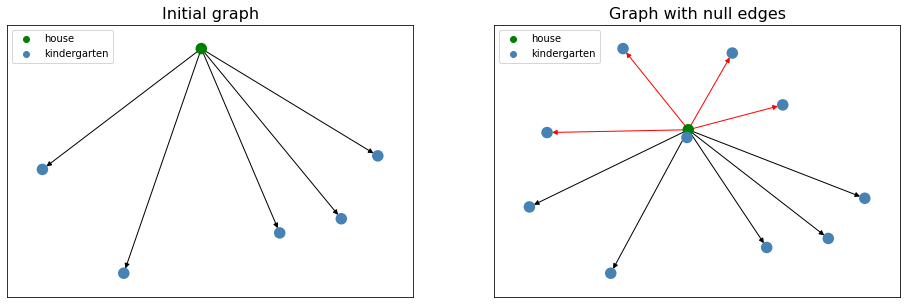

In [3]:
graph_example = nx.read_graphml("../23_10_22/data/kindergartens_model_2022_new.graphml", node_type=int)

draw_example(graph_example, 126600)
plt.show()

### Prepare dataset

In [9]:
class ProvisionDataset(InMemoryDataset):
    def __init__(self, root, transform=None):
        super(ProvisionDataset, self).__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        files = []
        for file in os.listdir(self.root):
            if file.endswith(".graphml"):
                files.append(file)
        return files
        
    @property
    def processed_file_names(self):
        return ['../provision.dataset']

    def download(self):
        pass
    
    def process(self):

        # read distance matrix to build null edges with distance as weights
        with open(os.path.join(self.root, "distance_matrix.json")) as f:
            file = json.load(f)
            matrix = pd.read_json(file)

        null_edge_ratio = 1
        accessibility_normative = 300 

        data_list = []
        for file in self.raw_file_names:
            
            # read DIRECTED graph
            graph = nx.read_graphml(os.path.join(self.root, file), node_type=int)
            del graph.graph['node_default'], graph.graph['edge_default']
            
            for u, d in graph.nodes(data=True):
                obj_type = 1. if d["type"] == "house" else 0.
                initial_value = float(d["demand"]) if "demand" in d else float(d["capacity"])
                d.clear()
                d["x"] = [obj_type, initial_value]
                d["id"] = u

            for u, v, d in graph.edges(data=True):
                d["is_available"] = 1. if d["distance"] <= accessibility_normative else 0.
                d["y"] = d["load"]
                del d["load"]

            x = np.array([[i, d["x"][0], d["x"][1]] for i, d in graph.nodes(data=True)])
            edges = np.array([[u, v, d["y"], d["is_available"], d["distance"]] for u, v, d in graph.edges(data=True)])
            houses_id = x[:, 0][x[:, 1] == 1]
            services_id = x[:, 0][x[:, 1] == 0]

            # add random null edges to graph
            # the number of null edges is equal to len(edges) * null_edge_ratio
            null_edges = []
            for h_id in houses_id:
                connected_services = edges[:, 1][edges[:, 0] == h_id]
                remain_services = [s for s in services_id if s not in connected_services]
                for i in range(len(connected_services) * null_edge_ratio):
                    s_id = np.random.choice(remain_services)
                    distance = matrix[h_id][s_id]
                    available = 1. if distance <= accessibility_normative else 0.
                    null_edges.append([h_id, s_id, {"y": 0., "is_available": available, "distance": distance}])
                    remain_services.remove(s_id)
            graph.add_edges_from(null_edges)

            # convert to UNDIRECTED graph (is it necessary?)
            # graph = graph.to_undirected()
            graph = pyg.utils.convert.from_networkx(graph, group_edge_attrs=["is_available", "distance"])
            graph.edge_attr = torch.tensor(graph.edge_attr.numpy(), dtype=torch.float32)

            # sort edge_index, edge_attr and y
            graph.edge_index, attr = pyg.utils.sort_edge_index(
                graph.edge_index, [graph.y, graph.edge_attr], graph.num_nodes, True
                )
            graph.y, graph.edge_attr = attr

            data_list.append(graph)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[0])

### NN configuration

In [10]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_conv_layers, dropout):
        super(GNNStack, self).__init__()

        self.mp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Dropout(dropout), 
            nn.Linear(hidden_dim, hidden_dim))

        self.convs = nn.ModuleList()
        self.num_conv_layers = num_conv_layers
        for l in range(self.num_conv_layers - 1):
            self.convs.append(pyg_nn.GCNConv(hidden_dim, hidden_dim))
        self.convs.append(pyg_nn.GCNConv(hidden_dim, output_dim))

        self.lns = nn.ModuleList()
        for l in range(self.num_conv_layers - 1):
            self.lns.append(nn.LayerNorm(hidden_dim))

        self.dropout = dropout

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, 1 / ((data.edge_attr[:, 1] + 1))

        x = self.mp(x)
        for i in range(self.num_conv_layers):
            x = self.convs[i](x, edge_index, edge_weight)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_conv_layers - 1:
                x = self.lns[i](x)

        return emb

class LoadPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LoadPredictor, self).__init__()

        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(input_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_dim, hidden_dim))
        self.lins.append(nn.Linear(hidden_dim, output_dim))

        self.dropout = dropout

    def normalize(self, x, edge_index, y):

        y_sum_i = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
        y_norm_i = y * x[:, 1][edge_index[0, :]] / (y_sum_i[edge_index[0]] + 3.4028e-38)
        y_sum_j = torch.zeros_like(x[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y)
        y_norm_j = y * x[:, 1][edge_index[1, :]] / (y_sum_j[edge_index[1]] + 3.4028e-38)

        return torch.min(y_norm_i, y_norm_j)

    def forward(self, emb, data):

        x, edge_index, edge_weight = data.x, data.edge_index, 1 / (data.edge_attr[:, 1] + 1)

        emb_x_i = emb[edge_index[0]]
        emb_x_j = emb[edge_index[1]]
        coef = edge_weight.reshape(len(edge_weight), -1) 
        y = torch.cat((emb_x_i, emb_x_j), dim=1) * coef
        for lin in self.lins[:-1]:
            y = lin(y) 
            y = torch.relu(y)
            y = F.dropout(y, p=self.dropout, training=self.training)
        y = self.lins[-1](y)
        y = F.relu(y).squeeze(1)
        y_norm = self.normalize(x, edge_index, y)  # normalize y based on house demand and kindergarten capacity
        return y_norm


### Train / Test model

In [11]:
def train(train_dataset, test_dataset, writer):

    input_dim_conv = 2
    hidden_dim_conv = 64
    output_dim_conv = 64
    num_conv_layers = 2

    link_hidden_dim = 64
    link_output_dim = 1
    num_linear_layer = 4

    dropout = 0.25

    # build model
    train_loader = DataLoader(train_dataset)
    model = GNNStack(input_dim_conv, hidden_dim_conv, output_dim_conv, num_conv_layers, dropout)
    load_predict = LoadPredictor(2 * output_dim_conv, link_hidden_dim, link_output_dim, num_linear_layer, dropout)
    optimize = optim.Adam(list(model.parameters()) + list(load_predict.parameters()),  lr=0.01)

    # train
    for epoch in range(200 + 1):
        model.train()
        load_predict.train()
        train_loss = []
        for train_data in train_loader:
            optimize.zero_grad()
            embedding = model(train_data)
            predict_y = load_predict(embedding, train_data)
            loss_function = torch.nn.MSELoss(reduction="mean")
            loss = loss_function(predict_y, train_data.y)
            train_loss.append(loss)
            loss.backward()
            optimize.step()
        mean_loss = sum(train_loss)/len(train_loss)
        writer.add_scalar("loss", mean_loss, epoch)

        if epoch % 10 == 0:
            metrics = test(test_dataset, model, load_predict)
            print(
                "Epoch {}. TRAIN: loss {:.4f}. TEST loss: {:.4f}, r2: {:.4f}, total error {:.4f}, standard deviation {:.4f}."\
                    .format(epoch, mean_loss, metrics["loss_test"], metrics["r2"], metrics["total_error"], metrics["std"])
                )
            for name, metrics in metrics.items():
                writer.add_scalar(name, metrics, epoch)

    return model, load_predict

def test(test_dataset, model, load_predict):

    model.eval()
    load_predict.eval()
    test_loader = DataLoader(test_dataset)
    for test_data in test_loader:
        with torch.no_grad():
            embedding = model(test_data)
            true_y = test_data.y
            predict_y = load_predict(embedding, test_data)
            loss = F.mse_loss(predict_y, test_data.y)
            r2 = metrics.r2_score(true_y, predict_y.detach().numpy())
            total_error = torch.sum(torch.abs(true_y - predict_y))
            std = torch.std(torch.abs(true_y - predict_y))

    return {"loss_test": loss, "r2": r2, "total_error": total_error, "std": std}

In [12]:
from tensorboardX import SummaryWriter
from datetime import datetime
writer = SummaryWriter("./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [66]:
dataset = ProvisionDataset("./data/")
dataset = dataset.shuffle()
train_dataset = dataset[:4]
test_dataset = dataset[4:]

m, p = train(train_dataset, test_dataset, writer)

Epoch 0. TRAIN: loss 154.3348. TEST loss: 113.3972, r2: 0.2637, total error 232435.8750, standard deviation 9.2124.
Epoch 10. TRAIN: loss 49.8561. TEST loss: 26.5543, r2: 0.8276, total error 77828.8750, standard deviation 4.8328.
Epoch 20. TRAIN: loss 31.0120. TEST loss: 17.7013, r2: 0.8851, total error 60036.3984, standard deviation 3.9747.
Epoch 30. TRAIN: loss 28.3381. TEST loss: 17.2608, r2: 0.8879, total error 64597.3828, standard deviation 3.8804.
Epoch 40. TRAIN: loss 27.9094. TEST loss: 16.8015, r2: 0.8909, total error 60204.8711, standard deviation 3.8585.
Epoch 50. TRAIN: loss 27.8595. TEST loss: 17.1501, r2: 0.8886, total error 64057.6211, standard deviation 3.8709.
Epoch 60. TRAIN: loss 27.0555. TEST loss: 16.9596, r2: 0.8899, total error 63473.1992, standard deviation 3.8513.
Epoch 70. TRAIN: loss 27.0313. TEST loss: 16.9884, r2: 0.8897, total error 65722.6719, standard deviation 3.8351.
Epoch 80. TRAIN: loss 26.6183. TEST loss: 16.3462, r2: 0.8939, total error 61353.1172,

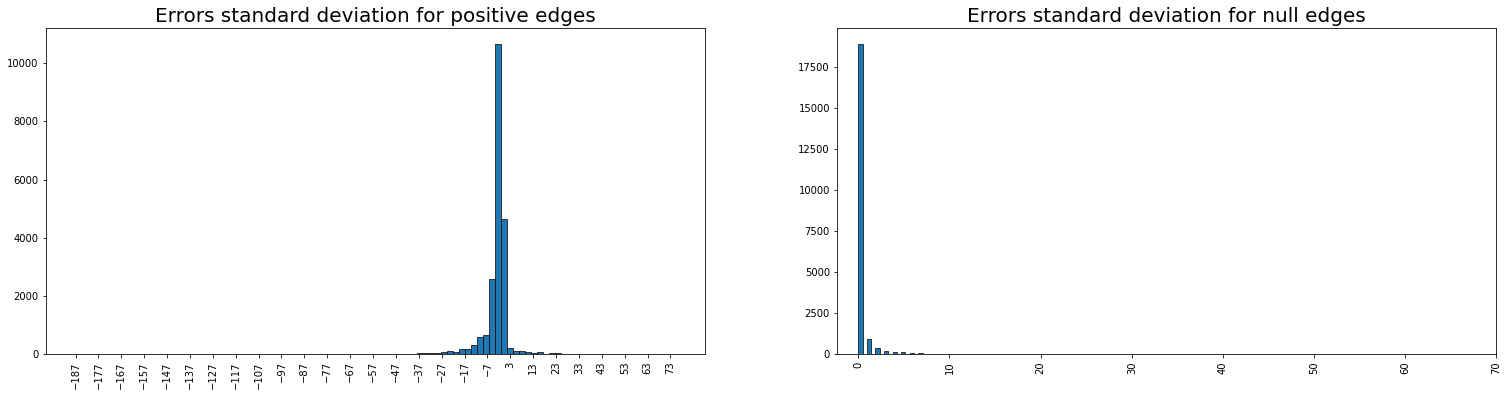

CPU times: user 1.48 s, sys: 185 ms, total: 1.66 s
Wall time: 590 ms


In [14]:
%%time
test_data = test_dataset[0]

with torch.no_grad():
    emb = m(test_data)
    link = test_data.edge_index
    predict_y = p(emb, test_data)
    errors = (torch.round(predict_y) - test_data.y).numpy()

errors_pos = errors[test_data.y > 0]
errors_neg = errors[test_data.y == 0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,6))
n_bins = 100
ax1.set_title("Errors standard deviation for positive edges", size=20)
ax1.hist(errors_pos, n_bins, edgecolor="black", linewidth=0.7)
plt.sca(ax1)
plt.xticks(list(range(int(min(errors_pos)), int(max(errors_pos)), 10)), rotation='vertical')
ax2.set_title("Errors standard deviation for null edges", size=20)
ax2.hist(errors_neg, n_bins, edgecolor="black", linewidth=0.7)
plt.sca(ax2)
plt.xticks(list(range(int(min(errors_neg)), int(max(errors_pos)), 10)), rotation='vertical')
  
plt.show()

### Test with fully connected graph

In [24]:
full_graph = torch.load("./test_data/test.pt")

In [56]:
normative = 300
max_distant = torch.max(full_graph.edge_attr[:, 1]).item()

iter_distances = [(0, normative)]
while iter_distances[-1][1] < max_distant:
    prev_distance = iter_distances[-1]
    iter_distances.append((prev_distance[1], prev_distance[1] * 2))

data_bunch = Data(x=full_graph.x, edge_index=torch.tensor([[],[]], dtype=torch.long), edge_attr=torch.tensor([]))

for min_dist, max_dist in tqdm(iter_distances):
    select = (full_graph.edge_attr[:, 1] > min_dist) & (full_graph.edge_attr[:, 1] <= max_dist) 
    data_bunch.edge_index = torch.cat((data_bunch.edge_index, full_graph.edge_index.T[select].T), axis=1)
    data_bunch.edge_attr = torch.cat((data_bunch.edge_attr, full_graph.edge_attr[select]))
    
    with torch.no_grad():
        emb = m(data_bunch)
        link = data_bunch.edge_index
        predict_y = p(emb, data_bunch)

    y_select = torch.round(predict_y) != 0
    predict_y = predict_y[y_select]
    data_bunch.edge_index = data_bunch.edge_index.T[y_select].T
    data_bunch.edge_attr = data_bunch.edge_attr[y_select]

100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


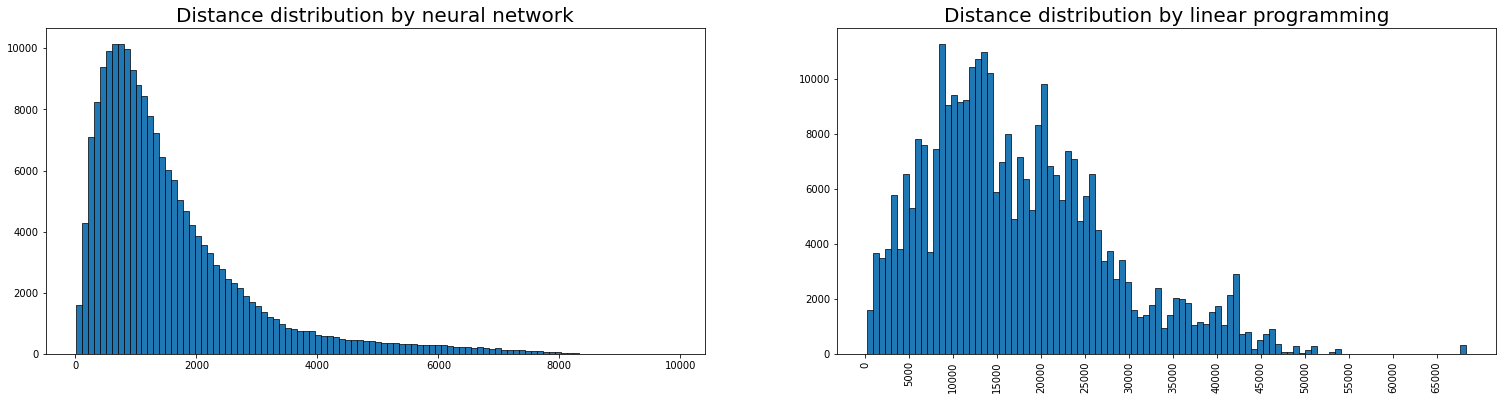

In [67]:
distanes_pr = data_bunch.edge_attr[:, 1]
num_people_pr = predict_y
distance_tr = full_graph.edge_attr[:, 1][full_graph.y !=0]
num_people_tr = full_graph.y[full_graph.y !=0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26,6))
n_bins = 100
ax1.set_title("Distance distribution by neural network", size=20)
ax1.hist(distanes_pr, n_bins, weights=num_people_pr, edgecolor="black", linewidth=0.7)
plt.sca(ax1)
ax2.set_title("Distance distribution by linear programming", size=20)
ax2.hist(distance_tr, n_bins, weights=num_people_tr, edgecolor="black", linewidth=0.7)
plt.sca(ax2)
plt.xticks([n - n % 5000 for n in range(int(min(distance_tr)), int(max(distance_tr)), 5000)], rotation='vertical')
  
plt.show()

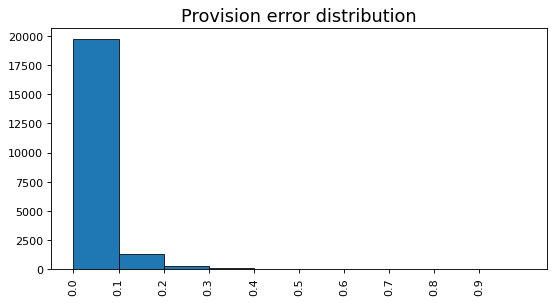

In [64]:
test_data = full_graph.clone()
test_data.edge_attr = full_graph.edge_attr[full_graph.y !=0]
test_data.edge_index = full_graph.edge_index.T[full_graph.y !=0].T
test_data.y = full_graph.y[full_graph.y !=0]

demand_sum = torch.sum((
    pyg.utils.to_dense_adj(test_data.edge_index, edge_attr=test_data.y)[0] * 
    pyg.utils.to_dense_adj(test_data.edge_index, edge_attr=test_data.edge_attr[:, 0])[0]), 
    dim=1)

provision_true = demand_sum[test_data.x[:, 0] == 1] / test_data.x[:, 1][test_data.x[:, 0] == 1]

demand_sum_predict = torch.sum((
    pyg.utils.to_dense_adj(data_bunch.edge_index, edge_attr=predict_y)[0] * 
    pyg.utils.to_dense_adj(data_bunch.edge_index, edge_attr=data_bunch.edge_attr[:, 0])[0]), 
    dim=1)
provision_predict = demand_sum_predict[data_bunch.x[:, 0] == 1] / data_bunch.x[:, 1][data_bunch.x[:, 0] == 1]

errors_provision=torch.abs((provision_true - provision_predict))

n_bins=10
plt.figure(figsize=(8, 4), dpi=80)
plt.title("Provision error distribution", size=16)
plt.hist(errors_provision, n_bins, edgecolor="black", linewidth=0.7)
plt.xticks(list(np.arange(0., 1., 0.1)), rotation='vertical')
plt.show()